<a href="https://colab.research.google.com/github/ezurakosuta/thebestclassifier/blob/main/CodigoFonte_TCC_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  %pip install yfinance

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt

# Defina os tickers e o período de análise de dados
tickers = ['ALSO3.SA', 'CPLE6.SA', 'HYPE3.SA', 'ITSA4.SA', 'ABEV3.SA', 'TIMS3.SA', 'ENBR3.SA', 'RADL3.SA', 'KLBN11.SA', 'TAEE11.SA']
start_date = '2018-01-01'
end_date = '2023-01-01'

# Baixa os preços de fechamento ajustados das ações na carteira
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

In [3]:
# Calcula os retornos logarítmicos anualizados e a matriz de covariância
returns = np.log(data / data.shift(1))
annual_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

In [4]:
# Define as funções que serão utilizadas no problema de optimização
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_return(weights):
    return np.sum(annual_returns * weights)

def portfolio_sharpe_ratio(weights):
    return -portfolio_return(weights) / portfolio_volatility(weights)

n = len(tickers)
max_stock_weight = 1
bounds = [(0, max_stock_weight) if i != (n-1) else (0, 1) for i in range(n)]
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
               {'type': 'ineq', 'fun': lambda x: x - 0.01})

In [5]:
# Criar um DataFrame vazio para armazenar os retornos anualizados para cada ticker
annual_returns_yearly = pd.DataFrame()

# Percorre o loop dos anos do início ao fim
for year in range(int(start_date[:4]), int(end_date[:4])):
    # Selecione os retornos para o ano atual
    returns_year = returns.loc[f"{year}-01-01":f"{year}-12-31"]

    # Calcula os retornos anualizados para cada ticker
    annual_returns_yearly[str(year)] = returns_year.mean() * 252

# Calcular o total de retornos anualizados para cada ticker
annual_returns_yearly['Retorno Total'] = annual_returns

# Printa o DataFrame com os retornos anuais por ano e por ticker
print(annual_returns_yearly.apply(lambda x: round(x*100, 2)).astype(str) + '%')

              2018    2019     2020     2021     2022 Retorno Total
ABEV3.SA   -32.06%  22.33%  -15.28%    2.88%   -0.89%        -4.53%
ALSO3.SA     5.02%  69.22%  -55.04%  -29.51%  -22.45%        -6.59%
CPLE6.SA    32.44%  87.52%   12.51%    2.38%   34.02%         33.8%
ENBR3.SA    11.53%  46.57%   -8.91%   11.78%    9.24%        14.04%
HYPE3.SA   -14.67%  20.56%   -0.52%  -15.64%   50.32%         8.15%
ITSA4.SA    26.89%  22.53%  -14.72%  -18.46%   11.94%         5.61%
KLBN11.SA    -8.2%  20.66%   36.87%    -1.6%  -17.28%         6.09%
RADL3.SA   -46.28%  68.85%   12.22%    -2.1%   -1.31%          6.4%
TAEE11.SA    23.3%  34.88%   18.21%    20.1%    3.34%        19.93%
TIMS3.SA    -9.34%  32.38%   -2.85%   -7.51%   -1.21%         2.32%


In [6]:
# Define o problema para encontrar os pesos que maximizam o índice Sharpe
initial_weights = np.ones(n) / n
result_max = minimize(portfolio_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights_max = result_max.x

# Calcula o retorno esperado e a volatilidade da carteira
expected_return_max = portfolio_return(optimal_weights_max)
volatility_max = portfolio_volatility(optimal_weights_max)

# Calcula o VaR paramétrico considerando um nível de confiança de 95%.
var_max = norm.ppf(1 - 0.95) * volatility_max

# Calcula o coeficiente de variação
cv_max = expected_return_max / volatility_max

# Printa o retorno esperado, volatilidade e VaR encontrados
print("Pesos ideais para a carteira com o índice Sharpe maximizado:")
for i, weight in enumerate(optimal_weights_max):
    print(f"{tickers[i]}: {weight * 100:.2f}%")
print(f"\nRetorno Esperado: {expected_return_max * 100:.2f}%")
print(f"Volatilidade ou Risco: {volatility_max * 100:.2f}%")
print(f"Value-at-Risk (95% de confiança): {-var_max * 100:.2f}%")
print(f"Coeficiente de Variação (CV): {cv_max:.2f}")

Pesos ideais para a carteira com o índice Sharpe maximizado:
ALSO3.SA: 1.00%
CPLE6.SA: 1.00%
HYPE3.SA: 32.59%
ITSA4.SA: 1.00%
ABEV3.SA: 1.00%
TIMS3.SA: 1.00%
ENBR3.SA: 1.00%
RADL3.SA: 1.00%
KLBN11.SA: 59.41%
TAEE11.SA: 1.00%

Retorno Esperado: 23.17%
Volatilidade ou Risco: 22.82%
Value-at-Risk (95% de confiança): 37.53%
Coeficiente de Variação (CV): 1.02


In [7]:
# Define o problema para encontrar os pesos que minimizem a volatilidade ou o risco
result_min = minimize(portfolio_volatility, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights_min = result_min.x

# Calcula o retorno esperado e a volatilidade da carteira
expected_minvol = portfolio_return(optimal_weights_min)
volatility_min = portfolio_volatility(optimal_weights_min)

# Calcula o VaR paramétrico considerando um nível de confiança de 95%.
var_min = norm.ppf(1 - 0.95) * volatility_min

# Calcula o coeficiente de variação
cv_min = expected_minvol / volatility_min

# Printa o retorno esperado, volatilidade e VaR encontrados
print("Pesos ideais para a carteira de variação mínima:")
for i, weight in enumerate(optimal_weights_min):
    print(f"{tickers[i]}: {weight * 100:.2f}%")
print(f"\nRetorno Esperado: {expected_minvol * 100:.2f}%")
print(f"Volatilidade ou Risco: {volatility_min * 100:.2f}%")
print(f"Value-at-Risk (95% de confiança): {-var_min * 100:.2f}%")
print(f"Coeficiente de Variação (CV): {cv_min:.2f}")

Pesos ideais para a carteira de variação mínima:
ALSO3.SA: 9.28%
CPLE6.SA: 1.00%
HYPE3.SA: 1.00%
ITSA4.SA: 3.74%
ABEV3.SA: 1.00%
TIMS3.SA: 1.00%
ENBR3.SA: 19.33%
RADL3.SA: 8.79%
KLBN11.SA: 50.46%
TAEE11.SA: 4.40%

Retorno Esperado: 12.41%
Volatilidade ou Risco: 18.37%
Value-at-Risk (95% de confiança): 30.22%
Coeficiente de Variação (CV): 0.68


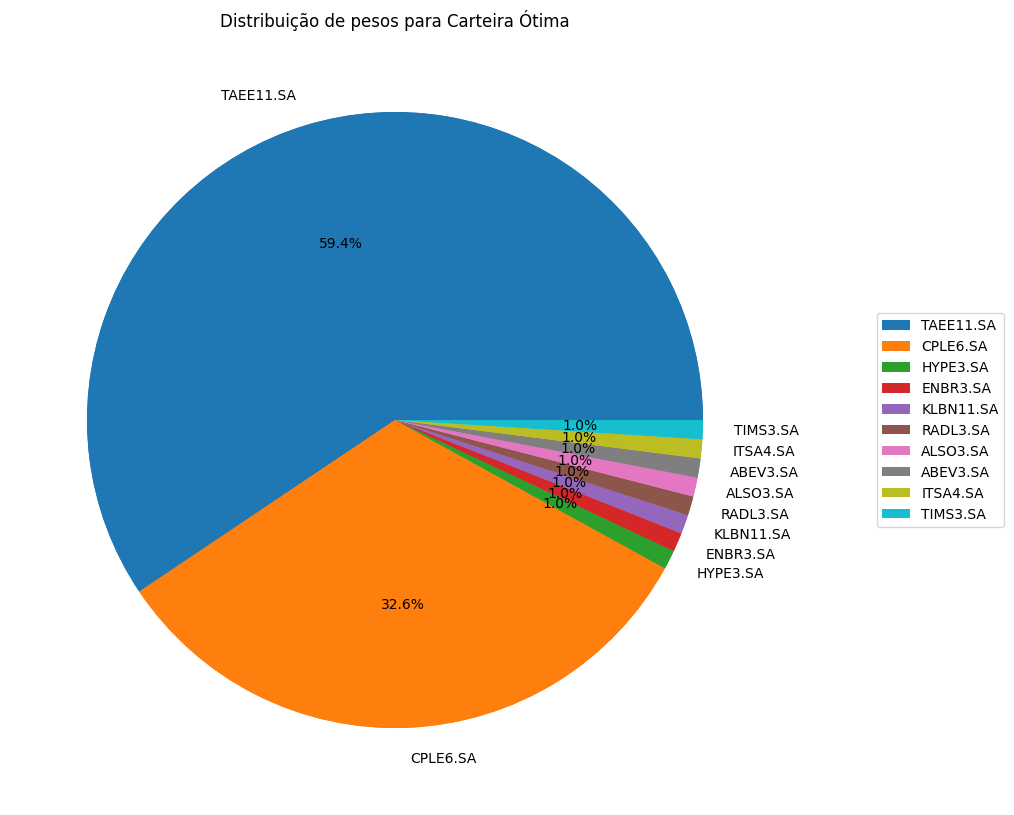

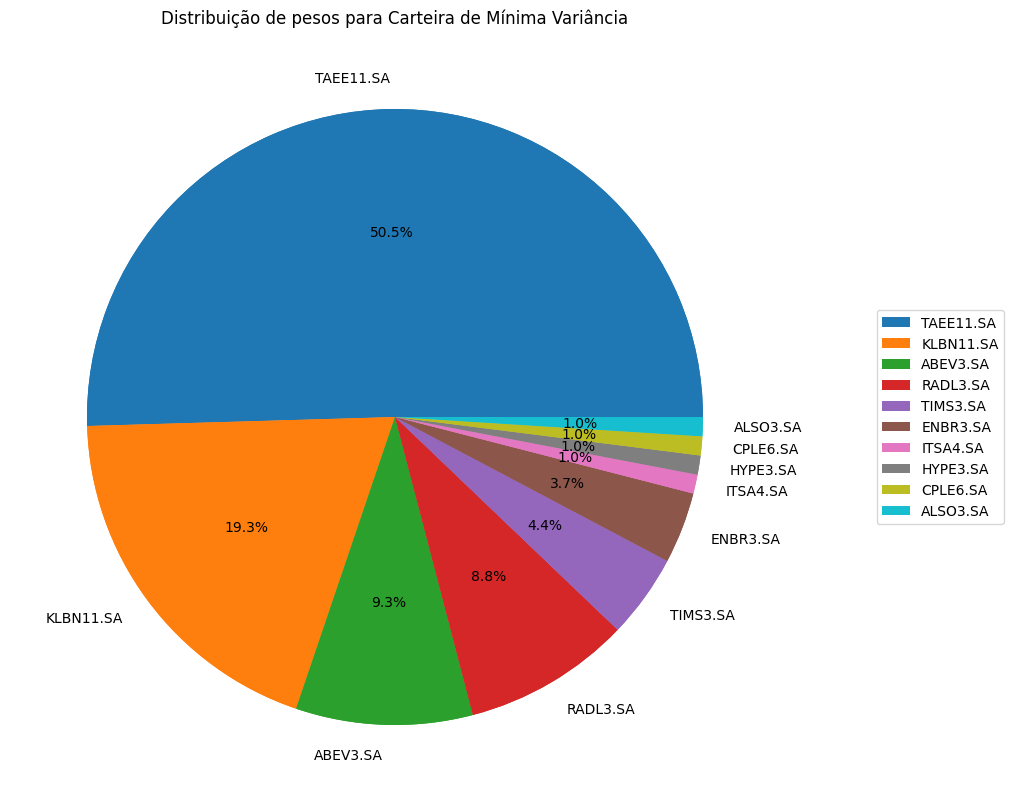

In [8]:
# Gera os gráficos que mostram os pesos de cada ativo dentro de suas respectivas carteiras
def plot_weights(weights, title):
    stocks = list(returns.columns)
    sorted_weights, sorted_stocks = zip(*sorted(zip(weights, stocks), reverse=True))
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.pie(sorted_weights, labels=sorted_stocks, autopct='%1.1f%%')
    ax.set_title(title)

    patches, texts = ax.pie(sorted_weights)
    ax.legend(patches, sorted_stocks, loc="center right", bbox_to_anchor=(1.3, 0.5))
    plt.show()

plot_weights(optimal_weights_max, "Distribuição de pesos para Carteira Ótima")
plot_weights(optimal_weights_min, "Distribuição de pesos para Carteira de Mínima Variância")

In [9]:
# Define a taxa livre de risco como SELIC ou 13,75%
risk_free_rate = 0.1375

# Define a função para encontrar a semivariância
def portfolio_semivariance(weights, risk_free_rate):
    weighted_daily_returns = (returns * weights).sum(axis=1)
    daily_risk_free_rate = (1 + risk_free_rate) ** (1/252) - 1
    downside_diff = np.where(weighted_daily_returns < daily_risk_free_rate, weighted_daily_returns - daily_risk_free_rate, 0)
    semivariance = np.mean(downside_diff ** 2)
    return semivariance

downside_risk_max = np.sqrt(252 * portfolio_semivariance(optimal_weights_max, risk_free_rate))
downside_risk_min = np.sqrt(252 * portfolio_semivariance(optimal_weights_min, risk_free_rate))

print(f"Downside Risk para o Portfólio com Índice Sharpe Maximizado: {downside_risk_max * 100:.2f}%")
print(f"Downside Risk para o Portfólio de Mínima Variância: {downside_risk_min * 100:.2f}%")

Downside Risk para o Portfólio com Índice Sharpe Maximizado: 16.23%
Downside Risk para o Portfólio de Mínima Variância: 13.71%


Pesos ideais:
ALSO3.SA: 1.00%
CPLE6.SA: 1.00%
HYPE3.SA: 32.59%
ITSA4.SA: 1.00%
ABEV3.SA: 1.00%
TIMS3.SA: 1.00%
ENBR3.SA: 1.00%
RADL3.SA: 1.00%
KLBN11.SA: 59.41%
TAEE11.SA: 1.00%
Peso máximo: 100%
Retorno esperado: 23.17%
Volatilidade: 22.82%
Value-at-Risk (95% de confiança): 37.53%
Coeficiente de Variação (CV): 1.02

Pesos ideais:
ALSO3.SA: 1.00%
CPLE6.SA: 1.00%
HYPE3.SA: 32.59%
ITSA4.SA: 1.00%
ABEV3.SA: 1.00%
TIMS3.SA: 1.00%
ENBR3.SA: 1.00%
RADL3.SA: 1.00%
KLBN11.SA: 59.41%
TAEE11.SA: 1.00%
Peso máximo: 90%
Retorno esperado: 23.17%
Volatilidade: 22.82%
Value-at-Risk (95% de confiança): 37.53%
Coeficiente de Variação (CV): 1.02

Pesos ideais:
ALSO3.SA: 1.00%
CPLE6.SA: 1.00%
HYPE3.SA: 32.59%
ITSA4.SA: 1.00%
ABEV3.SA: 1.00%
TIMS3.SA: 1.00%
ENBR3.SA: 1.00%
RADL3.SA: 1.00%
KLBN11.SA: 59.41%
TAEE11.SA: 1.00%
Peso máximo: 80%
Retorno esperado: 23.17%
Volatilidade: 22.82%
Value-at-Risk (95% de confiança): 37.53%
Coeficiente de Variação (CV): 1.02

Pesos ideais:
ALSO3.SA: 1.00%
CPLE6.SA: 1.00%

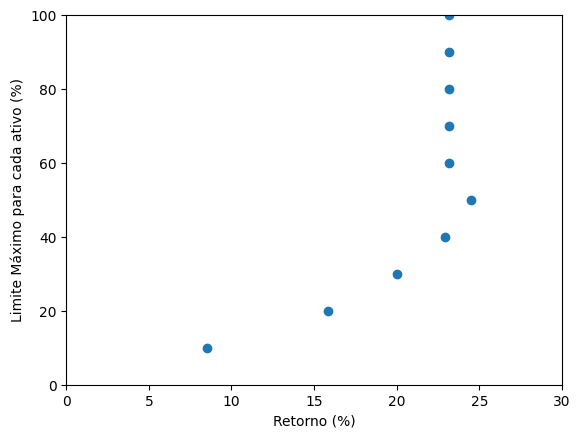

In [10]:
points = []

# Passa os limites superiores de peso de 100% a 10% em incrementos de 10%
for i in range(10, 0, -1):
    max_stock_weight = i / 10
    bounds = [(0, max_stock_weight) for _ in range(n)]

    # Soluciona o problema de otimização para os pesos ideais com o novo limite superior
    result = minimize(portfolio_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    optimal_weights = result.x

    # Calcula o retorno esperado e a volatilidade da carteira
    expected_return = portfolio_return(optimal_weights)
    volatility = portfolio_volatility(optimal_weights)

    # Calcula o VaR paramétrico a 95% de nível de confiança
    var = norm.ppf(1 - 0.95) * volatility

    # Calcula o coeficiente de variação
    cv = expected_return / volatility

    # Adiciona as coordenadas do ponto à lista
    points.append((expected_return * 100, max_stock_weight * 100))

    # Printa os resultados para cada limite superior de peso
    print("Pesos ideais:")
    for j, weight in enumerate(optimal_weights):
        print(f"{tickers[j]}: {weight * 100:.2f}%")
    print(f"Peso máximo: {max_stock_weight * 100:.0f}%")
    print(f"Retorno esperado: {expected_return * 100:.2f}%")
    print(f"Volatilidade: {volatility * 100:.2f}%")
    print(f"Value-at-Risk (95% de confiança): {-var * 100:.2f}%")
    print(f"Coeficiente de Variação (CV): {cv:.2f}\n")

# Cria o gráfico de dispersão
fig, ax = plt.subplots()
ax.scatter([p[0] for p in points], [p[1] for p in points])

# Adiciona os eixos e rótulos
ax.set_xlim([0, 30])
ax.set_ylim([0, 100])
ax.set_xlabel('Retorno (%)')
ax.set_ylabel('Limite Máximo para cada ativo (%)')

plt.show()

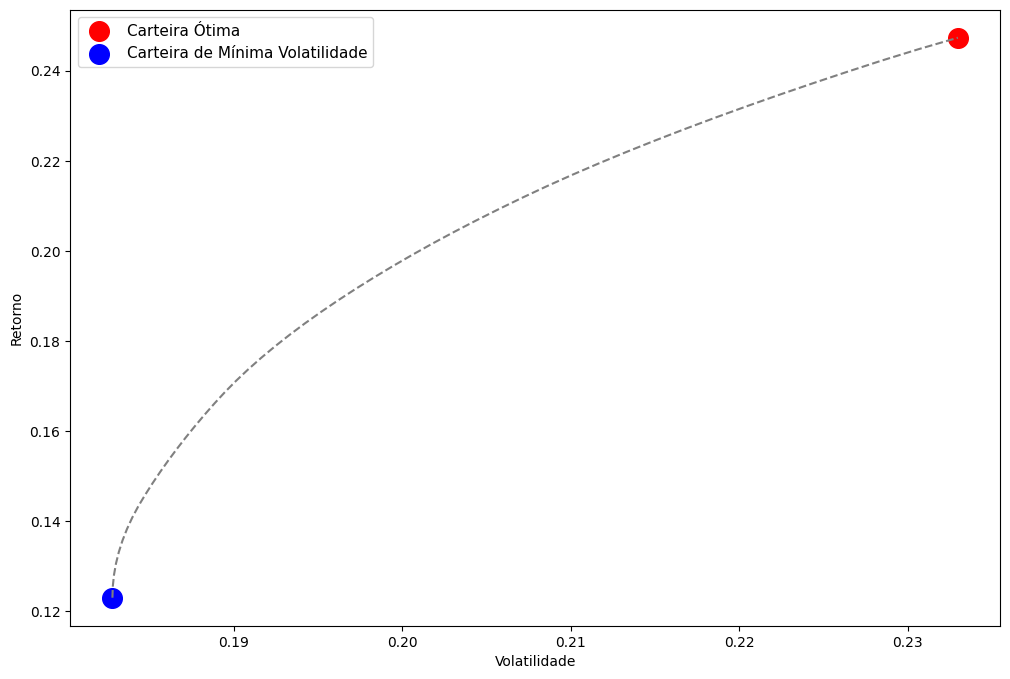

In [11]:
# Calcula a performance da carteira
def portfolio_performance(weights, annual_returns, cov_matrix):
    port_return = np.sum(annual_returns * weights)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_volatility

# Calcula maximiza Sharpe ao minimizar sua contrapartida negativa
def neg_sharpe_ratio(weights, annual_returns, cov_matrix):
    port_return, port_volatility = portfolio_performance(weights, annual_returns, cov_matrix)
    return -port_return / port_volatility
# Verifica se a soma dos pesos é igual a 1
def check_sum_to_one(weights):
    return np.sum(weights) - 1

# Define os limites para os pesos e as restrições para a soma dos pesos igual a 1
bounds = [(0, 1) for _ in range(n)]
constraints = {'type': 'eq', 'fun': check_sum_to_one}

# Palpite inicial igualmente distribuído entre as ações
initial_guess = [1 / n] * n

# Encontra os resultados para carteira de mínima volatilidade
min_vol_result = minimize(lambda x, *args: portfolio_performance(x, *args)[1], initial_guess, args=(annual_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
min_vol_weights = min_vol_result.x
expected_minvol, volatility_min = portfolio_performance(min_vol_weights, annual_returns, cov_matrix)

# Encontra os resultados para carteira ótima
max_sharpe_result = minimize(neg_sharpe_ratio, initial_guess, args=(annual_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
max_sharpe_weights = max_sharpe_result.x
expected_return_max, volatility_max = portfolio_performance(max_sharpe_weights, annual_returns, cov_matrix)

# Cria uma lista de retornos eficientes
eff_returns = np.linspace(expected_minvol, expected_return_max, 50)
eff_volatility = []

# Loop para encontrar a volatilidade eficiente para cada retorno eficiente
for eff_return in eff_returns:
    constraints = ({'type': 'eq', 'fun': lambda w: portfolio_performance(w, annual_returns, cov_matrix)[0] - eff_return},
                   {'type': 'eq', 'fun': check_sum_to_one})
    result = minimize(lambda x, *args: portfolio_performance(x, *args)[1], initial_guess, args=(annual_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
    eff_volatility.append(result.fun)

# Printa o gráfico da fronteira eficiente

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(volatility_max, expected_return_max, c='red', marker='o', s=200, label='Carteira Ótima')
ax.scatter(volatility_min, expected_minvol, c='blue', marker='o', s=200, label='Carteira de Mínima Volatilidade')
ax.plot(eff_volatility, eff_returns, '--', color='grey')

ax.set_xlabel('Volatilidade')
ax.set_ylabel('Retorno')
ax.legend(loc='upper left', fontsize=11)
plt.show()